Osnovna obdelava slik 
za teleskop ASA800 in kamera C5

In [1]:
import os
import numpy as np
from astropy.io import fits
from astropy.nddata import CCDData
from astropy.stats import mad_std
from astropy import units as u
import ccdproc as ccdp
from ccdproc import ImageFileCollection
from pathlib import Path

# da se znebim astropy INFO 
from astropy import log
log.setLevel('ERROR')
import warnings; warnings.simplefilter('ignore')


In [ ]:
# moji podatki za obdelavo so v mapi:
# relativno glede na to, kje je ta skripta


path = 'M2025-06-12/' 

NameError: name '__file__' is not defined

Najprej pripravim master bias

In [3]:
bias_folder = ImageFileCollection(path+'BIAS') 
bias_folder.summary['file', 'imagetyp', 'exptime', 'filter']

<Table length=10>
     file     imagetyp exptime filter
    str13       str4   float64  str2 
------------- -------- ------- ------
_Ha_0010.fits     BIAS    0.01     Ha
_Ha_0011.fits     BIAS    0.01     Ha
_Ha_0012.fits     BIAS    0.01     Ha
_Ha_0013.fits     BIAS    0.01     Ha
_Ha_0014.fits     BIAS    0.01     Ha
_Ha_0015.fits     BIAS    0.01     Ha
_Ha_0016.fits     BIAS    0.01     Ha
_Ha_0017.fits     BIAS    0.01     Ha
_Ha_0018.fits     BIAS    0.01     Ha
_Ha_0019.fits     BIAS    0.01     Ha

Pripravim si funkcijo, ki naredi slike 'normalno' velike, sicer se razbohoti na 3*float64 na piksel

In [4]:
def reduce_size(image, uncert=False):
	image.data = image.data.astype(np.float32)
	if uncert:
		image.uncertainty.array = None 
	else:
		image.uncertainty.array = image.uncertainty.array.astype(np.float32)
	image.mask = None    


Sestavim skupaj, metoda je average

In [5]:

calibrated_path = Path(path+'BIAS')
reduced_images = ImageFileCollection(calibrated_path)
calibrated_biases = reduced_images.files_filtered(imagetyp='BIAS', include_path=True)
combined_bias = ccdp.combine(calibrated_biases, method='average', unit='adu')

# za normalno velikost slike dam nazaj v float32 in brez dodatkov
combined_bias.meta['combined'] = True
reduce_size(combined_bias)

# master bias v mapo kalibracija
Bias_calcomb = Path(path, 'kalibracija')  
Bias_calcomb.mkdir(exist_ok=True) 
 
combined_bias.write(Bias_calcomb / 'master_bias.fit',overwrite=True) 


Pripravim master dark

In [6]:
# Najprej pogledam katere ekspozicije imam, 
# moja običajna mapa za slike je LIGHT,
# izjemoma tudi SNAPSHOT

path_images = Path(path+'LIGHT/')
path_darks = Path(path+'DARK/')

images_raw = ImageFileCollection(path_images)
darks_raw  = ImageFileCollection(path_darks)

# en lep izpis
images_raw.summary['file', 'imagetyp', 'exptime', 'filter']

<Table length=153>
         file         imagetyp exptime filter
        str21           str5   float64  str2 
--------------------- -------- ------- ------
   IC4665_B_0001.fits    LIGHT    60.0      B
   IC4665_B_0002.fits    LIGHT    60.0      B
   IC4665_B_0003.fits    LIGHT    60.0      B
   IC4665_B_0004.fits    LIGHT    60.0      B
   IC4665_B_0005.fits    LIGHT    60.0      B
   IC4665_B_0006.fits    LIGHT    60.0      B
   IC4665_B_0007.fits    LIGHT    60.0      B
   IC4665_B_0008.fits    LIGHT    60.0      B
   IC4665_B_0009.fits    LIGHT    60.0      B
                  ...      ...     ...    ...
NGC 7039_Ha_0015.fits    LIGHT   300.0     Ha
NGC 7039_Ha_0016.fits    LIGHT   300.0     Ha
NGC 7039_Ha_0017.fits    LIGHT   300.0     Ha
NGC 7039_Ha_0018.fits    LIGHT   300.0     Ha
NGC 7039_Ha_0019.fits    LIGHT   300.0     Ha
NGC 7039_Ha_0020.fits    LIGHT   300.0     Ha
NGC 7039_Ha_0021.fits    LIGHT   300.0     Ha
 NGC7039_Ha_0010.fits    LIGHT   300.0     Ha
 NGC7039_Ha_0011.fits    LIGHT   300.0     Ha
 NGC7039_Ha_0012.fits    LIGHT   300.0     Ha

In [7]:
# še darki
darks_raw.summary['file', 'imagetyp', 'exptime']

<Table length=10>
     file     imagetyp exptime
    str13       str4   float64
------------- -------- -------
_Ha_0010.fits     DARK    60.0
_Ha_0011.fits     DARK    60.0
_Ha_0012.fits     DARK    60.0
_Ha_0013.fits     DARK    60.0
_Ha_0014.fits     DARK    60.0
_Ha_0015.fits     DARK    60.0
_Ha_0016.fits     DARK    60.0
_Ha_0017.fits     DARK    60.0
_Ha_0018.fits     DARK    60.0
_Ha_0019.fits     DARK    60.0

In [8]:
dark_exptime = set(darks_raw.summary['exptime'])

print("darki=",dark_exptime)
print(darks_raw.summary['file'])

darki= {np.float64(60.0)}
     file    
-------------
_Ha_0010.fits
_Ha_0011.fits
_Ha_0012.fits
_Ha_0013.fits
_Ha_0014.fits
_Ha_0015.fits
_Ha_0016.fits
_Ha_0017.fits
_Ha_0018.fits
_Ha_0019.fits


In [9]:
# preverim master bias
image_name_bias = 'master_bias.fit' 
combined_bias = CCDData.read(Bias_calcomb / image_name_bias, unit='adu')

darks_1 = darks_raw.files_filtered(imagetyp='Dark')
combined_Dark=0

# najprej od darka odštejem bias
for j in range(0,len(darks_1)):
    combined_Dark = CCDData.read(path+'DARK/'+darks_1[j], unit='adu')
    ccd = ccdp.subtract_bias(combined_Dark, combined_bias)
    ccd.meta['combined'] = False
    name = 'dark_{id}.fits'.format(id=j)
    Dark_calcomb = Path(path, 'kalibracija')  
    Dark_calcomb.mkdir(exist_ok=True) 
    reduce_size(ccd)
    ccd.write(Dark_calcomb / name,overwrite=True)

In [10]:
#  pogledam kaj je narejeno in pripravim kolekcijo, 
#  filtriram tako da v seštevek vzame samo posnete darke 

darks_comb = ImageFileCollection(Dark_calcomb, keywords=['imagetyp', 'exptime', 'combined'])
calibrated_darks = darks_comb.filter(imagetyp='Dark', combined=False)
calibrated_darks.summary['file', 'imagetyp', 'exptime', 'combined']

<Table length=10>
                file                imagetyp exptime combined
               str35                  str4   float64   bool  
----------------------------------- -------- ------- --------
M2025-06-13/kalibracija/dark_0.fits     DARK    60.0    False
M2025-06-13/kalibracija/dark_1.fits     DARK    60.0    False
M2025-06-13/kalibracija/dark_2.fits     DARK    60.0    False
M2025-06-13/kalibracija/dark_3.fits     DARK    60.0    False
M2025-06-13/kalibracija/dark_4.fits     DARK    60.0    False
M2025-06-13/kalibracija/dark_5.fits     DARK    60.0    False
M2025-06-13/kalibracija/dark_6.fits     DARK    60.0    False
M2025-06-13/kalibracija/dark_7.fits     DARK    60.0    False
M2025-06-13/kalibracija/dark_8.fits     DARK    60.0    False
M2025-06-13/kalibracija/dark_9.fits     DARK    60.0    False

In [12]:
# sedaj imam darke brez biasa, ki so v mapi kalibracija
print("darki=",dark_exptime)

for exp_time in sorted(dark_exptime):
    # pripravim katere darke vzame v seštevek, filtriram še darke po ekspoziciji 
    darks_tosum = calibrated_darks.files_filtered(imagetyp='Dark', exptime=exp_time, include_path=True)
    combined_dark = ccdp.combine(darks_tosum,method='average',unit='adu')

    # označim da je že narejen master dark
    combined_dark.meta['combined'] = True
    reduce_size(combined_dark)

    # master dark za različne ekspozicije
    print(f"obdelujem dark {exp_time} z {len(darks_tosum)} slikami.")
    dark_file_name = f'master_dark_{exp_time}.fits'
    combined_dark.write(Dark_calcomb / dark_file_name, overwrite=True)
    
    print("izbrišem začasne darke ")
    for file in darks_tosum:
        os.unlink(file)
        print(file)



darki= {np.float64(60.0)}
obdelujem dark 60.0 z 10 slikami.
izbrišem začasne darke 
M2025-06-13/kalibracija/dark_0.fits
M2025-06-13/kalibracija/dark_1.fits
M2025-06-13/kalibracija/dark_2.fits
M2025-06-13/kalibracija/dark_3.fits
M2025-06-13/kalibracija/dark_4.fits
M2025-06-13/kalibracija/dark_5.fits
M2025-06-13/kalibracija/dark_6.fits
M2025-06-13/kalibracija/dark_7.fits
M2025-06-13/kalibracija/dark_8.fits
M2025-06-13/kalibracija/dark_9.fits


In [13]:
# Pogledam katere flate imamo

path_Flats = Path(path+'FLAT/')
flats_raw = ImageFileCollection(path_Flats)

flats_raw.summary['file', 'imagetyp', 'exptime', 'filter']

<Table length=21>
     file     imagetyp exptime filter
    str13       str4   float64  str2 
------------- -------- ------- ------
 _B_0007.fits     FLAT    10.0      B
 _B_0008.fits     FLAT    10.0      B
 _B_0009.fits     FLAT    10.0      B
 _B_0010.fits     FLAT    10.0      B
 _B_0011.fits     FLAT    10.0      B
 _B_0012.fits     FLAT    10.0      B
 _B_0013.fits     FLAT    10.0      B
 _G_0007.fits     FLAT    10.0      G
 _G_0008.fits     FLAT    10.0      G
 _G_0009.fits     FLAT    10.0      G
 _G_0010.fits     FLAT    10.0      G
 _G_0011.fits     FLAT    10.0      G
 _G_0012.fits     FLAT    10.0      G
 _G_0013.fits     FLAT    10.0      G
_Ha_0007.fits     FLAT    60.0     Ha
_Ha_0008.fits     FLAT    60.0     Ha
_Ha_0009.fits     FLAT    60.0     Ha
_Ha_0010.fits     FLAT    60.0     Ha
_Ha_0011.fits     FLAT    60.0     Ha
_Ha_0012.fits     FLAT    60.0     Ha
_Ha_0013.fits     FLAT    60.0     Ha

In [14]:
# in katere filtre
flat_filters = set(h['filter'] for h in flats_raw.headers(imagetyp='Flat'))
flat_exp =     set(h['exptime'] for h in flats_raw.headers(imagetyp='Flat'))
print(flat_filters)
print(flat_exp)

{'Ha', 'G', 'B'}
{10.0, 60.0}


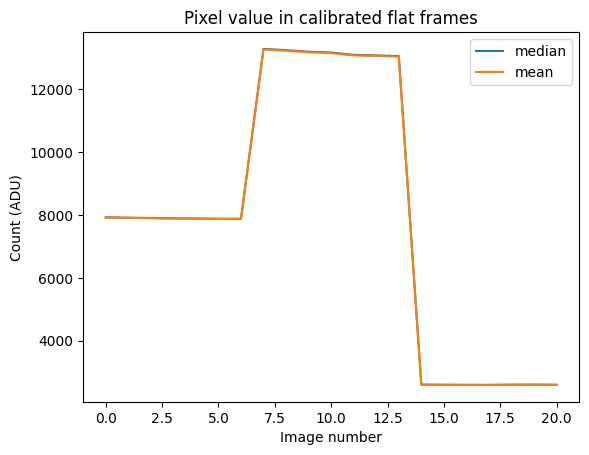

In [15]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm


median_count = [np.median(data) for data in flats_raw.data(imagetyp='Flat')]
mean_count = [np.mean(data) for data in flats_raw.data(imagetyp='Flat')]
plt.plot(median_count, label='median')
plt.plot(mean_count, label='mean')
plt.xlabel('Image number')
plt.ylabel('Count (ADU)')
plt.title('Pixel value in calibrated flat frames')
plt.legend()


In [16]:
# vsi master darki so
darks_master = ImageFileCollection(Dark_calcomb, glob_include='*master_dark*')
master_dark_exposures = set(h['exptime'] for h in darks_master.headers(imagetyp='Dark'))
master_dark_exposures

{60.0}

In [17]:
def find_master_dark(myList, myNumber):
	return min(myList, key=lambda x:abs(x-myNumber))



In [18]:
# testiranje funkcije
exp=50  # primer ekspozicije
dark_exp = find_master_dark(master_dark_exposures, exp)
print(dark_exp)
master_dark = darks_master.files_filtered(exptime=dark_exp, include_path=True)[0]

master_dark

60.0


'M2025-06-13/kalibracija/master_dark_60.0.fits'

In [19]:
# pripravim vse možne master darke v slovar
d = {}
for exp in sorted(master_dark_exposures):
	master_dark_name = f'master_dark_{exp}.fits'
	print(exp, master_dark_name)
	d[exp] = CCDData.read(Dark_calcomb /master_dark_name, unit='adu')



60.0 master_dark_60.0.fits


In [20]:
# pripravim master bias 
# master darke že imam v d slovarju, 


combined_bias  = CCDData.read(Bias_calcomb / 'master_bias.fit', unit='adu')


flats_1 = flats_raw.files_filtered(imagetyp='Flat')
combined_Flat=0


Flat_calcomb = Path(path, 'kalibracija')  
Flat_calcomb.mkdir(exist_ok=True) 

# odštejem bias in dark in naredim Flats_X.fits
for j in range(0,len(flats_1)):
    combined_Flat = CCDData.read(path+'FLAT/'+flats_1[j], unit='adu')

    exp = combined_Flat.meta['exposure'] 
    dark_exp = find_master_dark(master_dark_exposures, exp)
    master_dark_name = f'master_dark_{dark_exp}.fits'
    print(f"obdelujem flat {flats_1[j]} z darkom {master_dark_name}")

    combined_Dark  = d[dark_exp]

    ccd = ccdp.subtract_bias(combined_Flat, combined_bias)
    ccd = ccdp.subtract_dark(ccd, combined_Dark, exposure_time='exptime', exposure_unit=u.second, scale=True)
    ccd.meta['combined'] = False
    
    reduce_size(ccd)
    name = 'flats_{id}.fits'.format(id=j)
    ccd.write(Flat_calcomb / name,overwrite=True)

obdelujem flat _B_0007.fits z darkom master_dark_60.0.fits
obdelujem flat _B_0008.fits z darkom master_dark_60.0.fits
obdelujem flat _B_0009.fits z darkom master_dark_60.0.fits
obdelujem flat _B_0010.fits z darkom master_dark_60.0.fits
obdelujem flat _B_0011.fits z darkom master_dark_60.0.fits
obdelujem flat _B_0012.fits z darkom master_dark_60.0.fits
obdelujem flat _B_0013.fits z darkom master_dark_60.0.fits
obdelujem flat _G_0007.fits z darkom master_dark_60.0.fits
obdelujem flat _G_0008.fits z darkom master_dark_60.0.fits
obdelujem flat _G_0009.fits z darkom master_dark_60.0.fits
obdelujem flat _G_0010.fits z darkom master_dark_60.0.fits
obdelujem flat _G_0011.fits z darkom master_dark_60.0.fits
obdelujem flat _G_0012.fits z darkom master_dark_60.0.fits
obdelujem flat _G_0013.fits z darkom master_dark_60.0.fits
obdelujem flat _Ha_0007.fits z darkom master_dark_60.0.fits
obdelujem flat _Ha_0008.fits z darkom master_dark_60.0.fits
obdelujem flat _Ha_0009.fits z darkom master_dark_60.0

In [21]:
# pripravim flate za seštevanje
path_flats_1 = Path(path+'kalibracija/')

flats1 = ImageFileCollection(path_flats_1, keywords=['imagetyp', 'exptime', 'filter', 'combined'])
flats_tosum = flats1.filter(imagetyp='Flat', combined=False)
flats_tosum.summary['file', 'imagetyp', 'exptime', 'filter']




<Table length=21>
                 file                 imagetyp exptime filter
                str37                   str4   float64  str2 
------------------------------------- -------- ------- ------
 M2025-06-13/kalibracija/flats_0.fits     FLAT    10.0      B
 M2025-06-13/kalibracija/flats_1.fits     FLAT    10.0      B
M2025-06-13/kalibracija/flats_10.fits     FLAT    10.0      G
M2025-06-13/kalibracija/flats_11.fits     FLAT    10.0      G
M2025-06-13/kalibracija/flats_12.fits     FLAT    10.0      G
M2025-06-13/kalibracija/flats_13.fits     FLAT    10.0      G
M2025-06-13/kalibracija/flats_14.fits     FLAT    60.0     Ha
M2025-06-13/kalibracija/flats_15.fits     FLAT    60.0     Ha
M2025-06-13/kalibracija/flats_16.fits     FLAT    60.0     Ha
M2025-06-13/kalibracija/flats_17.fits     FLAT    60.0     Ha
M2025-06-13/kalibracija/flats_18.fits     FLAT    60.0     Ha
M2025-06-13/kalibracija/flats_19.fits     FLAT    60.0     Ha
 M2025-06-13/kalibracija/flats_2.fits     FLAT    10.0      B
M2025-06-13/kalibracija/flats_20.fits     FLAT    60.0     Ha
 M2025-06-13/kalibracija/flats_3.fits     FLAT    10.0      B
 M2025-06-13/kalibracija/flats_4.fits     FLAT    10.0      B
 M2025-06-13/kalibracija/flats_5.fits     FLAT    10.0      B
 M2025-06-13/kalibracija/flats_6.fits     FLAT    10.0      B
 M2025-06-13/kalibracija/flats_7.fits     FLAT    10.0      G
 M2025-06-13/kalibracija/flats_8.fits     FLAT    10.0      G
 M2025-06-13/kalibracija/flats_9.fits     FLAT    10.0      G

In [22]:
def inv_median(a):
    return 1 / np.median(a)

In [24]:

for filt in flat_filters:
    # sestavim master flat za vsak filter
    
    print(f"Obdelujem filter: {filt}")
    to_combine = flats_tosum.files_filtered(imagetyp='Flat', filter=filt, include_path=True)
    combined_flat = ccdp.combine(to_combine, method='average',scale=inv_median, unit='adu')

    combined_flat.meta['combined'] = True
    reduce_size(combined_flat)

    Flat_file_name = 'master_flat_{}.fits'.format(filt.replace("''", "p"))
    combined_flat.write(path_flats_1 / Flat_file_name, overwrite=True)
    print(Flat_file_name)
    
    print("izbrišem vmesne flate")
    for file in to_combine:
        print(file)    
        os.unlink(file)

Obdelujem filter: Ha
master_flat_Ha.fits
izbrišem vmesne flate
M2025-06-13/kalibracija/flats_14.fits
M2025-06-13/kalibracija/flats_15.fits
M2025-06-13/kalibracija/flats_16.fits
M2025-06-13/kalibracija/flats_17.fits
M2025-06-13/kalibracija/flats_18.fits
M2025-06-13/kalibracija/flats_19.fits
M2025-06-13/kalibracija/flats_20.fits
Obdelujem filter: G
master_flat_G.fits
izbrišem vmesne flate
M2025-06-13/kalibracija/flats_10.fits
M2025-06-13/kalibracija/flats_11.fits
M2025-06-13/kalibracija/flats_12.fits
M2025-06-13/kalibracija/flats_13.fits
M2025-06-13/kalibracija/flats_7.fits
M2025-06-13/kalibracija/flats_8.fits
M2025-06-13/kalibracija/flats_9.fits
Obdelujem filter: B
master_flat_B.fits
izbrišem vmesne flate
M2025-06-13/kalibracija/flats_0.fits
M2025-06-13/kalibracija/flats_1.fits
M2025-06-13/kalibracija/flats_2.fits
M2025-06-13/kalibracija/flats_3.fits
M2025-06-13/kalibracija/flats_4.fits
M2025-06-13/kalibracija/flats_5.fits
M2025-06-13/kalibracija/flats_6.fits


Obdelava znanstvenih (LIGHT) slik

In [25]:
from astropy.nddata import CCDData
from astropy.stats import mad_std
from astropy import units as u
import ccdproc as ccdp
from pathlib import Path





In [62]:
# odprem znanstvene slike

path_img = Path(path, 'LIGHT')  

img_raw = ImageFileCollection(path_img, glob_include='*.fits', glob_exclude='*_none_*')
img_raw.summary['file', 'imagetyp', 'exptime', 'filter']


<Table length=150>
         file         imagetyp exptime filter
        str21           str5   float64  str2 
--------------------- -------- ------- ------
   IC4665_B_0001.fits    LIGHT    60.0      B
   IC4665_B_0002.fits    LIGHT    60.0      B
   IC4665_B_0003.fits    LIGHT    60.0      B
   IC4665_B_0004.fits    LIGHT    60.0      B
   IC4665_B_0005.fits    LIGHT    60.0      B
   IC4665_B_0006.fits    LIGHT    60.0      B
   IC4665_B_0007.fits    LIGHT    60.0      B
   IC4665_B_0008.fits    LIGHT    60.0      B
   IC4665_B_0009.fits    LIGHT    60.0      B
                  ...      ...     ...    ...
NGC 7039_Ha_0012.fits    LIGHT   300.0     Ha
NGC 7039_Ha_0013.fits    LIGHT   300.0     Ha
NGC 7039_Ha_0014.fits    LIGHT   300.0     Ha
NGC 7039_Ha_0015.fits    LIGHT   300.0     Ha
NGC 7039_Ha_0016.fits    LIGHT   300.0     Ha
NGC 7039_Ha_0017.fits    LIGHT   300.0     Ha
NGC 7039_Ha_0018.fits    LIGHT   300.0     Ha
NGC 7039_Ha_0019.fits    LIGHT   300.0     Ha
NGC 7039_Ha_0020.fits    LIGHT   300.0     Ha
NGC 7039_Ha_0021.fits    LIGHT   300.0     Ha

In [63]:
# Lahko še izbiram slike, ki so v obdelavi
science_imagetyp = 'LIGHT'

Science_raw = img_raw.files_filtered(imagetyp=science_imagetyp,filter='Ha', include_path=False)  
print("Slike v obdelavi so: ",Science_raw)

# pripravim novo mapo za obdelane slike
reduced_path = Path(path, 'obdelano')  
reduced_path.mkdir(exist_ok=True) 


Slike v obdelavi so:  ['NGC 7039_Ha_0010.fits' 'NGC 7039_Ha_0011.fits' 'NGC 7039_Ha_0012.fits'
 'NGC 7039_Ha_0013.fits' 'NGC 7039_Ha_0014.fits' 'NGC 7039_Ha_0015.fits'
 'NGC 7039_Ha_0016.fits' 'NGC 7039_Ha_0017.fits' 'NGC 7039_Ha_0018.fits'
 'NGC 7039_Ha_0019.fits' 'NGC 7039_Ha_0020.fits' 'NGC 7039_Ha_0021.fits']


In [60]:
# naložim master kalibracijske slike


flat_imagetyp = 'FLAT'
exposure = 'exptime'

combined_bias = CCDData.read(Dark_calcomb / 'master_bias.fit')

path_flats=path+'kalibracija/'
flats_reduced_t = ImageFileCollection(path_flats, keywords=['imagetyp', 'exptime', 'filter', 'combined'])

combined_flats = {ccd.header['filter']: ccd for ccd in flats_reduced_t.ccds(imagetyp='Flat', combined=True)}
print("master flati so: ", combined_flats.keys())
flats_reduced_t.summary['file', 'imagetyp', 'exptime', 'filter', 'combined']



master flati so:  dict_keys(['B', 'G', 'Ha'])


<Table length=5>
        file        imagetyp exptime filter combined
       str21          str4   float64  str2    bool  
------------------- -------- ------- ------ --------
                 --     BIAS    0.01     Ha     True
                 --     DARK    60.0     Ha     True
 master_flat_B.fits     FLAT    10.0      B     True
 master_flat_G.fits     FLAT    10.0      G     True
master_flat_Ha.fits     FLAT    60.0     Ha     True

In [33]:
import numpy as np
from scipy.ndimage import median_filter

def find_outlier_pixels(data,tolerance=3,worry_about_edges=True):
    #This function finds the hot or dead pixels in a 2D dataset. 
    #tolerance is the number of standard deviations used to cutoff the hot pixels
    #If you want to ignore the edges and greatly speed up the code, then set
    #worry_about_edges to False.
    #
    #The function returns a list of hot pixels and also an image with with hot pixels removed

    blurred = median_filter(data, size=3, mode='reflect')
    difference = data - blurred
    #print('std=',np.std(difference)) 
    threshold = tolerance*np.std(difference)

    #find the hot pixels, but ignore the edges
    hot_pixels = np.nonzero((np.abs(difference[1:-1,1:-1])>threshold) )
    hot_pixels = np.array(hot_pixels) + 1 #because we ignored the first row and first column

    fixed_image = np.copy(data) #This is the image with the hot pixels removed
    for y,x in zip(hot_pixels[0],hot_pixels[1]):
        fixed_image[y,x]=blurred[y,x]
        
    if worry_about_edges == True:
        height,width = np.shape(data)
    
        ###Now get the pixels on the edges (but not the corners)###

        #left and right sides
        for index in range(1,height-1):
            #left side:
            med  = np.median(data[index-1:index+2,0:2])
            diff = np.abs(data[index,0] - med)
            if diff>threshold: 
                hot_pixels = np.hstack(( hot_pixels, [[index],[0]]  ))
                fixed_image[index,0] = med
            
            #right side:
            med  = np.median(data[index-1:index+2,-2:])
            diff = np.abs(data[index,-1] - med)
            if diff>threshold: 
                hot_pixels = np.hstack(( hot_pixels, [[index],[width-1]]  ))
                fixed_image[index,-1] = med

        #Then the top and bottom
        for index in range(1,width-1):
            #bottom:
            med  = np.median(data[0:2,index-1:index+2])
            diff = np.abs(data[0,index] - med)
            if diff>threshold: 
                hot_pixels = np.hstack(( hot_pixels, [[0],[index]]  ))
                fixed_image[0,index] = med
            
            #top:
            med  = np.median(data[-2:,index-1:index+2])
            diff = np.abs(data[-1,index] - med)
            if diff>threshold: 
                hot_pixels = np.hstack(( hot_pixels, [[height-1],[index]]  ))
                fixed_image[-1,index] = med
                  
        ###Then the corners###

        #bottom left
        med  = np.median(data[0:2,0:2])
        diff = np.abs(data[0,0] - med)
        if diff>threshold: 
            hot_pixels = np.hstack(( hot_pixels, [[0],[0]]  ))
            fixed_image[0,0] = med
        
        #bottom right
        med  = np.median(data[0:2,-2:])
        diff = np.abs(data[0,-1] - med)
        if diff>threshold: 
            hot_pixels = np.hstack(( hot_pixels, [[0],[width-1]]  ))
            fixed_image[0,-1] = med

        #top left
        med  = np.median(data[-2:,0:2])
        diff = np.abs(data[-1,0] - med)
        if diff>threshold: 
            hot_pixels = np.hstack(( hot_pixels, [[height-1],[0]]  ))
            fixed_image[-1,0] = med

        #top right
        med  = np.median(data[-2:,-2:])
        diff = np.abs(data[-1,-1] - med)
        if diff>threshold: 
            hot_pixels = np.hstack(( hot_pixels, [[height-1],[width-1]]  ))
            fixed_image[-1,-1] = med
    
    return hot_pixels,fixed_image, blurred, difference, threshold


In [ ]:
# testiranje funkcije
from astropy.io import fits


input_filename = "M2025-06-13/LIGHT/NGC 7039_Ha_0010.fits"
output_filename = 'M2025-06-13/obdelano/NGC7039_Ha_0010_h.fits'


science    = CCDData.read( input_filename, unit='adu', uncertainty=None)
science_b  = ccdp.subtract_bias(science, combined_bias)

exp = science.meta['exposure'] 
dark_exp = find_master_dark(master_dark_exposures, exp)
print(f"Using master dark for exposure {exp}: {dark_exp}")
combined_Dark  = d[dark_exp]

science_bd = ccdp.subtract_dark(science_b, combined_Dark, 
                                    exposure_time='exptime', 
                                    exposure_unit=u.second,
                                    scale=True)

fil = science_bd.meta['filter']
if  fil in combined_flats.keys():
    # če imam master flat za filter, ga uporabim
    good_flat = combined_flats[science_bd.header['filter']]
    print(f"Using master flat for filter {science_bd.header['filter']}")
    science_bdf = ccdp.flat_correct(science_bd, good_flat, min_value=1.0)	

else:
    print(f"No master flat found for filter {science_bd.header['filter']}. Using uncorrected data.")
    science_bdf = science_bd
    
Z = science_bdf.data.astype(np.float32) 


hot_pixels, science_bdf.data, _, _, threshold = find_outlier_pixels(Z,tolerance=3,worry_about_edges=False)
print('Hot pixels found: ', len(hot_pixels[0]))
print('Threshold for outliers: ', threshold)

science_bdf.data = science_bdf.data.astype(np.float32)
science_bdf.uncertainty.array = None 
science_bdf.mask = None    

science_bdf.write(output_filename, overwrite=True)




Using master dark for exposure 300.0: 60.0
Using master flat for filter Ha
Hot pixels found:  1630
Threshold for outliers:  1170.2927


In [64]:
from astropy.time import Time
from datetime import datetime

# obdelam vse slike v mapi 'LIGHT/'
for j in range(0,len(Science_raw)):
    
    science    = CCDData.read(path_img / Science_raw[j], unit='adu', uncertainty=None)
    science_b  = ccdp.subtract_bias(science, combined_bias)

    exp = science.meta['exposure'] 
    dark_exp = find_master_dark(master_dark_exposures, exp)
    print(f"Using master dark for exposure {exp}: {dark_exp}")
    combined_Dark  = d[dark_exp]

    # odštejem master dark
    science_bd = ccdp.subtract_dark(science_b, combined_Dark, 
                                    exposure_time='exptime', 
                                    exposure_unit=u.second,
                                    scale=True)

    fil = science_bd.meta['filter']
    if  fil in combined_flats.keys():
        # če imam master flat za filter, ga uporabim
        good_flat = combined_flats[science_bd.header['filter']]
        print(f"Using master flat for filter {science_bd.header['filter']}")
        science_bdf = ccdp.flat_correct(science_bd, good_flat, min_value=1.0)	
    else:
        print(f"No master flat found for filter {science_bd.header['filter']}. Using uncorrected data.")
        science_bdf = science_bd


    # popravek za hot pixel
    Z = science_bdf.data.astype(np.float32)

    hot_pixels, science_bdf.data, _, _, threshold = find_outlier_pixels(Z,tolerance=3,worry_about_edges=True)
    print('treshold=',threshold)
    print('Hot pixels found: ', len(hot_pixels[0]))
    

    # tudi varianta, ampak slabše
    #science_bdfh = ccdp.cosmicray_lacosmic(science_bdf, sigclip=5.0, sigfrac=0.3, objlim=5.0)

    science_bdf.data[science_bdf.data < 0] = 0
    # slike naredimo spet 16 bitne in izbrišem dodatke
    science_bdf.data = science_bdf.data.astype(np.uint16)
    science_bdf.uncertainty.array = None 
    science_bdf.mask = None    

    #datum = Time(datetime.now(),scale='utc')
    #datum_str = datum.strftime('%Y %b %d %H:%M:%S')
    #science_bdf.header['ZEROCOR'] = datum_str +' Zero level correction image is  ' 
    #science_bdf.header['DARKCOR'] = datum_str +' Dark count correction image is  ' 
    #science_bdf.header['FLATCOR'] = datum_str +' Flat field image is ' 
    #science_bdf.header['CCDPROC'] = datum_str +' CCD processing done '     

    # popravim ime, brez presledkov in oklepajev
    Science_new_name = Science_raw[j].replace(' ','').replace(')','').replace('(','_')

    # dodam še nekaj metapodatkov za kamero STM8300 
    science_bdf.header['RDNOISE'] = 9.3
    science_bdf.header['GAIN']    = 0.37

    science_bdf.write(reduced_path / Science_new_name, overwrite=True)
    print('slika: ', reduced_path /Science_new_name, 'obdelana')


    

Using master dark for exposure 300.0: 60.0
Using master flat for filter Ha
treshold= 1170.2927
Hot pixels found:  1630
slika:  M2025-06-13/obdelano/NGC7039_Ha_0010.fits obdelana
Using master dark for exposure 300.0: 60.0
Using master flat for filter Ha
treshold= 1167.11
Hot pixels found:  1599
slika:  M2025-06-13/obdelano/NGC7039_Ha_0011.fits obdelana
Using master dark for exposure 300.0: 60.0
Using master flat for filter Ha
treshold= 1169.116
Hot pixels found:  1454
slika:  M2025-06-13/obdelano/NGC7039_Ha_0012.fits obdelana
Using master dark for exposure 300.0: 60.0
Using master flat for filter Ha
treshold= 1166.5702
Hot pixels found:  1492
slika:  M2025-06-13/obdelano/NGC7039_Ha_0013.fits obdelana
Using master dark for exposure 300.0: 60.0
Using master flat for filter Ha
treshold= 1164.2363
Hot pixels found:  1396
slika:  M2025-06-13/obdelano/NGC7039_Ha_0014.fits obdelana
Using master dark for exposure 300.0: 60.0
Using master flat for filter Ha
treshold= 1165.1237
Hot pixels found: 

In [ ]:
"""
CMOS kamera C5A/C5S-150M
Gain number 	Gain in dB 	Gain multiply 	Conversion factor 	Read noise RMS 	Full well capacity
0   	         0,0 dB 	   1× 	0,76 e-/ADU 	3,52 e- 	50 000 e-
2749 	         9,7 dB 	   3× 	0,25 e-/ADU 	3,13 e- 	16 500 e-
2750 	         9,7 dB 	   3× 	0,25 e-/ADU 	1,51 e- 	16 500 e-
4030 	         36,0 dB 	   63× 	0,012 e-/ADU 	1,28 e- 	800 e-
""" 


'\nCMOS kamera C5A/C5S-150M\nGain number \tGain in dB \tGain multiply \tConversion factor \tRead noise RMS \tFull well capacity\n0   \t         0,0 dB \t   1× \t0,76 e-/ADU \t3,52 e- \t50 000 e-\n2749 \t         9,7 dB \t   3× \t0,25 e-/ADU \t3,13 e- \t16 500 e-\n2750 \t         9,7 dB \t   3× \t0,25 e-/ADU \t1,51 e- \t16 500 e-\n4030 \t         36,0 dB \t   63× \t0,012 e-/ADU \t1,28 e- \t800 e-\n'